# Introducing Keras

Let's use Keras on the MNIST handwriting data set, using a Convolutional Neural Network that's suited for image processing. CNN's are less sensitive to where in the image the pattern is that we're looking for.

We'll start by importing the stuff we need:

In [1]:
import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

We'll load up our raw data set:

In [2]:
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


Since we're treating the data as 2D images of 28x28 pixels, we need to shape it accordingly. Depending on the data format Keras is set up for, this may be 1x28x28 or 28x28x1 (the "1" indicates a single color channel, as this is just grayscale. If we were dealing with color images, it would be 3 instead of 1 since we'd have red, green, and blue color channels)

In [26]:
from tensorflow.keras import backend as K

if K.image_data_format() == 'channels_first':
    train_images = mnist_train_images.reshape(mnist_train_images.shape[0], 1, 28, 28)
    test_images = mnist_test_images.reshape(mnist_test_images.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    train_images = mnist_train_images.reshape(mnist_train_images.shape[0], 28, 28, 1)
    test_images = mnist_test_images.reshape(mnist_test_images.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)
    
train_images[0].shape
train_images[0].reshape([28,28]).shape

(28, 28)

In [ ]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images /= 255
test_images /= 255

In [11]:
K.image_data_format()

'channels_last'

We need to convert our train and test labels to be categorical in one-hot format:

In [25]:
train_labels = tensorflow.keras.utils.to_categorical(mnist_train_labels, 10)
test_labels = tensorflow.keras.utils.to_categorical(mnist_test_labels, 10)
len(train_labels)
train_labels[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

As a sanity check let's print out one of the training images with its label:

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


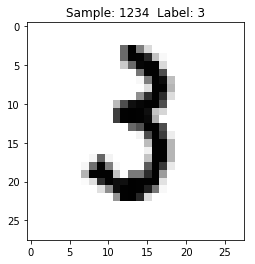

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def display_sample(num):
    #Print the one-hot array of this sample's label 
    print(train_labels[num])  
    #Print the label converted back to a number
    label = train_labels[num].argmax(axis=0)
    #Reshape the 768 values to a 28x28 image
    image = train_images[num].reshape([28,28])
    plt.title('Sample: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
display_sample(1234)

Now for the meat of the problem. Setting up a convolutional neural network involves more layers.

We'll start with a 2D convolution of the image - it's set up to take 32 windows, or "filters", of each image, each filter being 3x3 in size.

We then run a second convolution on top of that with 64 3x3 windows - this topology is just what comes recommended within Keras's own examples. Again you want to re-use previous research whenever possible while tuning CNN's, as it is hard to do.

Next we apply a MaxPooling2D layer that takes the maximum of each 2x2 result to distill the results down into something more manageable.

Next we flatten the 2D layer we have at this stage into a 1D layer. So at this point we can just pretend we have a traditional multi-layer perceptron...

... and feed that into a hidden, flat layer of 128 units.


And finally, we feed that into our final 10 units where softmax is applied to choose our category of 0-9.

In [7]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
# 64 3x3 kernels
model.add(Conv2D(64, (3, 3), activation='relu'))
# Reduce by taking the max of each 2x2 block
model.add(MaxPooling2D(pool_size=(2, 2)))
# Flatten the results to one dimension for passing into our final layer
model.add(Flatten())
# A hidden layer to learn with
model.add(Dense(128, activation='relu'))
# Final categorization from 0-9 with softmax
model.add(Dense(10, activation='softmax'))

Let's double check the model description:

### model.summary()

We are doing multiple categorization, so categorical_crossentropy is still the right loss function to use. We'll use the Adam optimizer, although the example provided with Keras uses RMSProp. You might want to try both if you have time.

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

And now we train our model... to make things go a little faster, we'll use batches of 32.

## Warning

This will take a few minutes to run on a p3.large instance.

In [10]:
history = model.fit(train_images, train_labels,
                    batch_size=32,
                    epochs=10,
                    verbose=2,
                    validation_data=(test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 - 50s - loss: 0.1133 - acc: 0.9659 - val_loss: 0.0465 - val_acc: 0.9840
Epoch 2/10
60000/60000 - 49s - loss: 0.0367 - acc: 0.9882 - val_loss: 0.0338 - val_acc: 0.9890
Epoch 3/10
60000/60000 - 52s - loss: 0.0227 - acc: 0.9930 - val_loss: 0.0311 - val_acc: 0.9892
Epoch 4/10
60000/60000 - 50s - loss: 0.0154 - acc: 0.9947 - val_loss: 0.0413 - val_acc: 0.9878
Epoch 5/10
60000/60000 - 51s - loss: 0.0122 - acc: 0.9962 - val_loss: 0.0295 - val_acc: 0.9916
Epoch 6/10
60000/60000 - 51s - loss: 0.0084 - acc: 0.9973 - val_loss: 0.0372 - val_acc: 0.9897
Epoch 7/10
60000/60000 - 50s - loss: 0.0075 - acc: 0.9975 - val_loss: 0.0373 - val_acc: 0.9904
Epoch 8/10
60000/60000 - 50s - loss: 0.0070 - acc: 0.9977 - val_loss: 0.0365 - val_acc: 0.9907
Epoch 9/10
60000/60000 - 49s - loss: 0.0037 - acc: 0.9988 - val_loss: 0.0428 - val_acc: 0.9908
Epoch 10/10
60000/60000 - 50s - loss: 0.0051 - acc: 0.9986 - val_loss: 0.0441 - val_acc: 0.9897

So, you can see that we started overfitting pretty early on, as our accuracy on the test set started exceeding our accuracy on the validation set. Our validation accuracy maxed out at around 99.0% after just a couple of epochs, while our accuracy on the test set kept climbing.

To prevent overfitting, we need to perform some sort of regularization. Dropout layers are one such technique in deep learning; they work by "dropping out" neurons on each pass to force learning to spread itself out across the network as a whole.

In [10]:
def MakeModel():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    # 64 3x3 kernels
    model.add(Conv2D(64, (3, 3), activation='relu'))
    # Reduce by taking the max of each 2x2 block
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Dropout to avoid overfitting
    model.add(Dropout(0.25))
    # Flatten the results to one dimension for passing into our final layer
    model.add(Flatten())
    # A hidden layer to learn with
    model.add(Dense(128, activation='relu'))
    # Another dropout
    model.add(Dropout(0.5))
    # Final categorization from 0-9 with softmax
    model.add(Dense(10, activation='softmax'))
    return model

model = MakeModel()

Let's run it again with those two dropout layers added in.

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
history = model.fit(train_images, train_labels,
                    batch_size=32,
                    epochs=10,
                    verbose=2,
                    validation_data=(test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 - 14s - loss: 0.2002 - acc: 0.9395 - val_loss: 0.0430 - val_acc: 0.9860
Epoch 2/10
60000/60000 - 13s - loss: 0.0801 - acc: 0.9756 - val_loss: 0.0332 - val_acc: 0.9889
Epoch 3/10
60000/60000 - 13s - loss: 0.0638 - acc: 0.9808 - val_loss: 0.0299 - val_acc: 0.9905
Epoch 4/10
60000/60000 - 13s - loss: 0.0495 - acc: 0.9844 - val_loss: 0.0310 - val_acc: 0.9901
Epoch 5/10
60000/60000 - 13s - loss: 0.0424 - acc: 0.9867 - val_loss: 0.0294 - val_acc: 0.9916
Epoch 6/10
60000/60000 - 13s - loss: 0.0371 - acc: 0.9887 - val_loss: 0.0242 - val_acc: 0.9928
Epoch 7/10
60000/60000 - 13s - loss: 0.0337 - acc: 0.9900 - val_loss: 0.0338 - val_acc: 0.9902
Epoch 8/10
60000/60000 - 13s - loss: 0.0299 - acc: 0.9908 - val_loss: 0.0286 - val_acc: 0.9922
Epoch 9/10
60000/60000 - 13s - loss: 0.0271 - acc: 0.9918 - val_loss: 0.0290 - val_acc: 0.9916
Epoch 10/10
60000/60000 - 13s - loss: 0.0267 - acc: 0.9915 - val_loss: 0.0280 - val_acc: 0.9934

That's better; our train and test accuracy ended up about the same, at 99.2%. There may still be a tiny bit of overfitting going on, but it's a lot better.

Let's also explore the effect the batch size has; as an experiment, let's increase it up to 1000:

In [14]:
model = MakeModel()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_images, train_labels,
                    batch_size=1000,
                    epochs=10,
                    verbose=2,
                    validation_data=(test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 - 5s - loss: 0.5228 - acc: 0.8367 - val_loss: 0.1356 - val_acc: 0.9591
Epoch 2/10
60000/60000 - 5s - loss: 0.1576 - acc: 0.9541 - val_loss: 0.0656 - val_acc: 0.9791
Epoch 3/10
60000/60000 - 5s - loss: 0.1021 - acc: 0.9701 - val_loss: 0.0520 - val_acc: 0.9828
Epoch 4/10
60000/60000 - 5s - loss: 0.0794 - acc: 0.9770 - val_loss: 0.0429 - val_acc: 0.9857
Epoch 5/10
60000/60000 - 5s - loss: 0.0675 - acc: 0.9805 - val_loss: 0.0351 - val_acc: 0.9872
Epoch 6/10
60000/60000 - 5s - loss: 0.0574 - acc: 0.9819 - val_loss: 0.0343 - val_acc: 0.9875
Epoch 7/10
60000/60000 - 5s - loss: 0.0513 - acc: 0.9842 - val_loss: 0.0340 - val_acc: 0.9888
Epoch 8/10
60000/60000 - 5s - loss: 0.0456 - acc: 0.9858 - val_loss: 0.0340 - val_acc: 0.9886
Epoch 9/10
60000/60000 - 5s - loss: 0.0422 - acc: 0.9870 - val_loss: 0.0324 - val_acc: 0.9885
Epoch 10/10
60000/60000 - 5s - loss: 0.0384 - acc: 0.9878 - val_loss: 0.0305 - val_acc: 0.9899


If you run this block a few times, you'll probably get very different results. Large batch sizes tend to get stuck in "local minima", and converge on the wrong solution at random. Smaller batch sizes also have a regularization effect. Sometimes you'll get lucky and the large batch will converge on a good solution; other times, not so much.

Let's explore the effect of the learning rate. The default learning rate for Adam is 0.001; let's see what happens if we increase it by an order of magnitude to 0.01:

In [19]:
model = MakeModel()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

adam = tensorflow.keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [20]:
history = model.fit(train_images, train_labels,
                    batch_size=32,
                    epochs=10,
                    verbose=2,
                    validation_data=(test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 - 14s - loss: 0.6022 - acc: 0.8092 - val_loss: 0.2194 - val_acc: 0.9310
Epoch 2/10
60000/60000 - 13s - loss: 0.4404 - acc: 0.8649 - val_loss: 0.1900 - val_acc: 0.9447
Epoch 3/10
60000/60000 - 13s - loss: 0.4128 - acc: 0.8720 - val_loss: 0.1991 - val_acc: 0.9378
Epoch 4/10
60000/60000 - 13s - loss: 0.3939 - acc: 0.8781 - val_loss: 0.1523 - val_acc: 0.9529
Epoch 5/10
60000/60000 - 13s - loss: 0.3925 - acc: 0.8792 - val_loss: 0.1614 - val_acc: 0.9504
Epoch 6/10
60000/60000 - 13s - loss: 0.3821 - acc: 0.8848 - val_loss: 0.1778 - val_acc: 0.9453
Epoch 7/10
60000/60000 - 13s - loss: 0.3787 - acc: 0.8839 - val_loss: 0.1638 - val_acc: 0.9515
Epoch 8/10
60000/60000 - 13s - loss: 0.3734 - acc: 0.8856 - val_loss: 0.1787 - val_acc: 0.9491
Epoch 9/10
60000/60000 - 13s - loss: 0.3688 - acc: 0.8893 - val_loss: 0.1564 - val_acc: 0.9522
Epoch 10/10
60000/60000 - 13s - loss: 0.3652 - acc: 0.8899 - val_loss: 0.1497 - val_acc: 0.9530

Yikes! That had a huge, and terrible, effect on the results. Small batch sizes are best paired with low learning rates, and large learning rates have a tendency to overshoot the correct solution entirely - which is probably what happened here. The learning rate is an example of a hyperparameter that you might want to tune by just trying different values; we'll see more of that later in the course.